In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # has not effect

import sys
sys.path.append("../")
device="cuda"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

In [4]:
saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [6]:
os.makedirs(args.model_path, exist_ok=True)
opt_gaussians = GaussianModel(3)
opt_scene = Scene(dataset, opt_gaussians, shuffle=True)
opt_gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [7]:

# opt_gaussians.restore(torch.load("./fit_hotdog_with_lego_200clusters/chkpnt1.pth")[0], opt)
#opt_gaussians.restore(torch.load("./fit_hotdog_with_lego_150clusters_percep_loss/chkpnt1.pth")[0], opt)
# opt_gaussians.restore(torch.load("./fit_hotdog_with_coast_rocks_40clusters/chkpnt1.pth")[0], opt)
#opt_gaussians.restore(torch.load("./fit_hotdog_with_coast_rocks_40clusters_fitted_with_sh/chkpnt1.pth")[0], opt)
opt_gaussians.restore(torch.load("./fit_hotdog_with_lego_200_clusters_v2_colored/chkpnt1.pth")[0], opt)



In [8]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = opt_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))



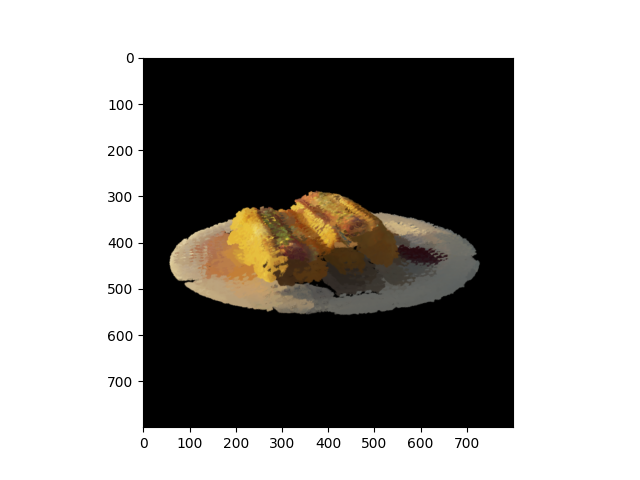

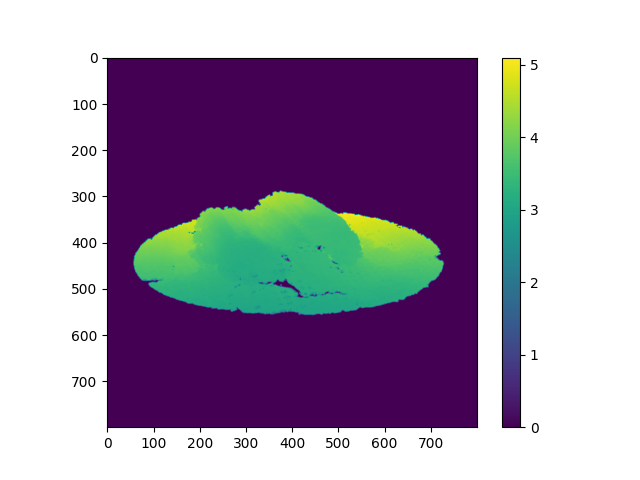

In [9]:

render_pkg_opt = render(viewpoint_cam, opt_gaussians, pipe, background)
image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]

image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_opt.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


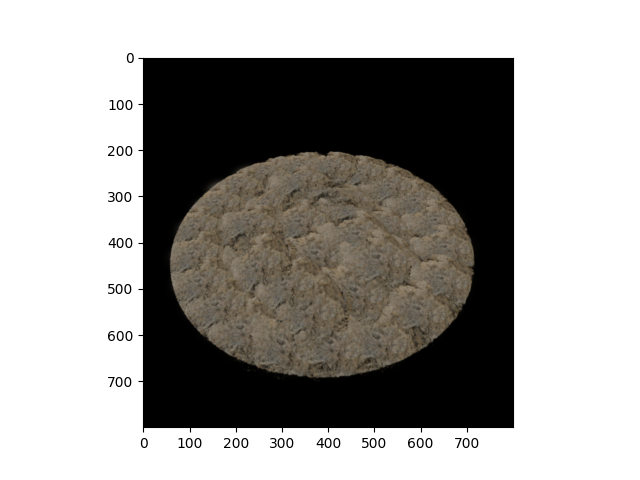

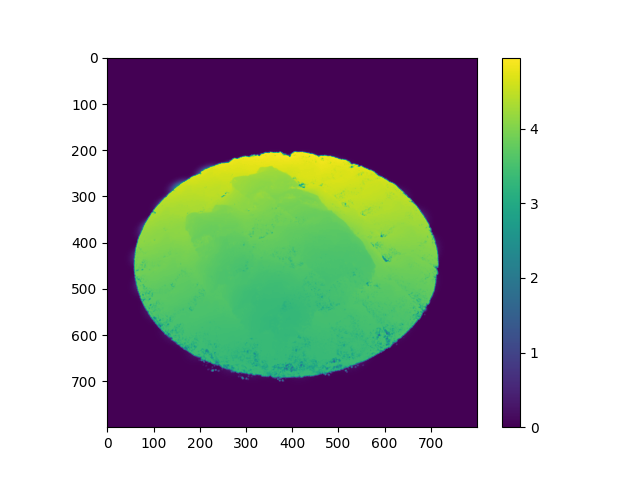

In [42]:

render_pkg_opt = render(viewpoint_cam, opt_gaussians, pipe, background)
image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]

image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_opt.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


In [10]:
import kornia
def shade_image(img_color, img_normals, 
                drct_lght_color = np.array([1., 1., 1.]), drct_lght_dir = np.array([0., 0., 1.]),
                ambnt_lght=np.array([0.1, 0.1, 0.1]) ):
    """
    Relights the image given by the color of every pixel and its normals. Additionally use the sf
    Implementation is taken from this video https://youtu.be/wOyavGx28uU?t=1084 .
    :param img_color: numpy array of shape [H,W,D] with values in [0,1]
    :param img_normals: numpy array of shape [H,W,D] with values in [0,1] and norm along last dim is 1
    :param 
    
    """
    
    drct_lght_color = np.expand_dims(np.expand_dims(drct_lght_color, axis=0), axis=0)
    ambnt_lght = np.expand_dims(np.expand_dims(ambnt_lght, axis=0), axis=0)
    drct_lght_dir = drct_lght_dir / (1e-6 + np.linalg.norm(drct_lght_dir))
    reflected_light = drct_lght_color * np.expand_dims(np.clip(np.dot(img_normals, drct_lght_dir), 0.,1.), axis=-1)
    #reflected_light = reflected_light / (1e-6 + np.linalg.norm(reflected_light))
    #print(reflected_light)
    #print(np.max(reflected_light))
    color =  img_color * np.clip((reflected_light*(1.-np.max(ambnt_lght))+ambnt_lght) ,0.,1.)
    return color 
    
    
    
    
    

In [11]:
K = torch.tensor([[1111, 0, 400],
                  [0, 1111, 400],
                  [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
normals = kornia.geometry.depth.depth_to_normals(depth=depth_opt.unsqueeze(0).unsqueeze(0),
                                                 camera_matrix=K,
                                                 normalize_points=False)
image_normals = normals.squeeze(0)
mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
image_normals = (image_normals - mins) / (maxs - mins + 1e-6)

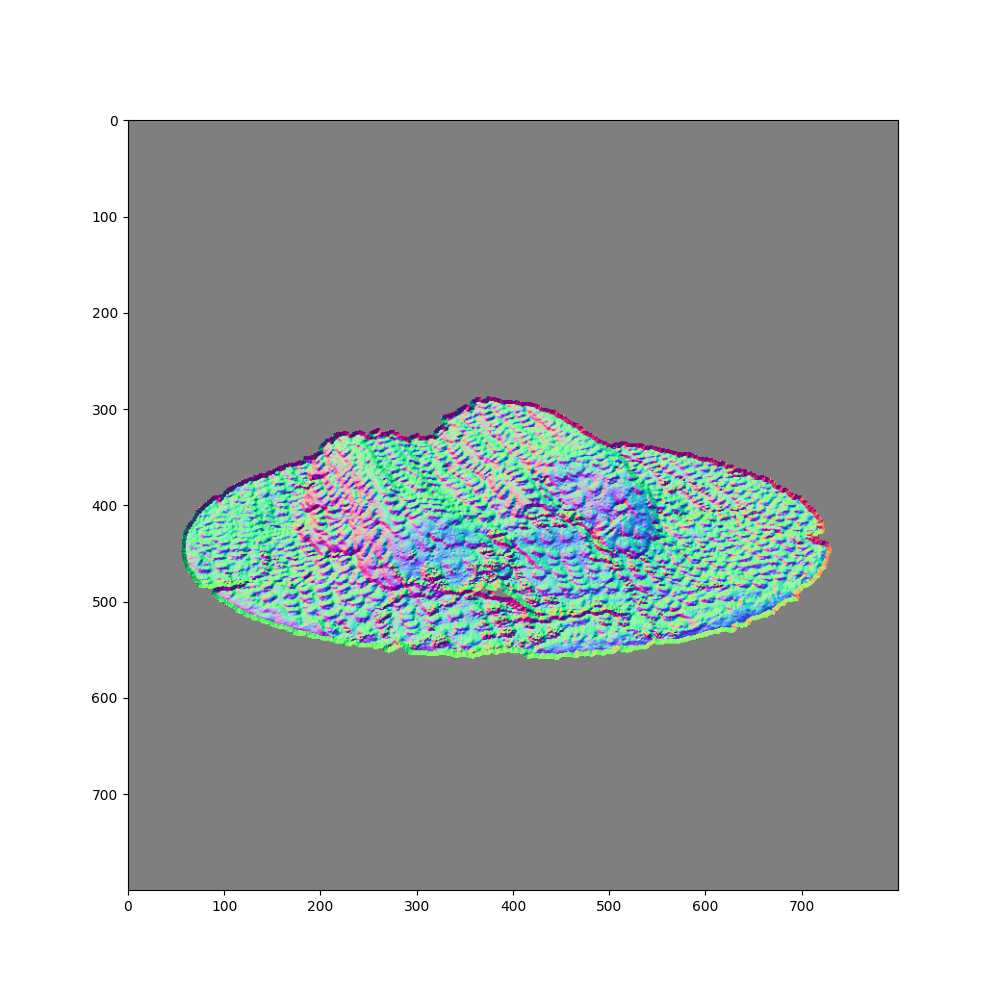

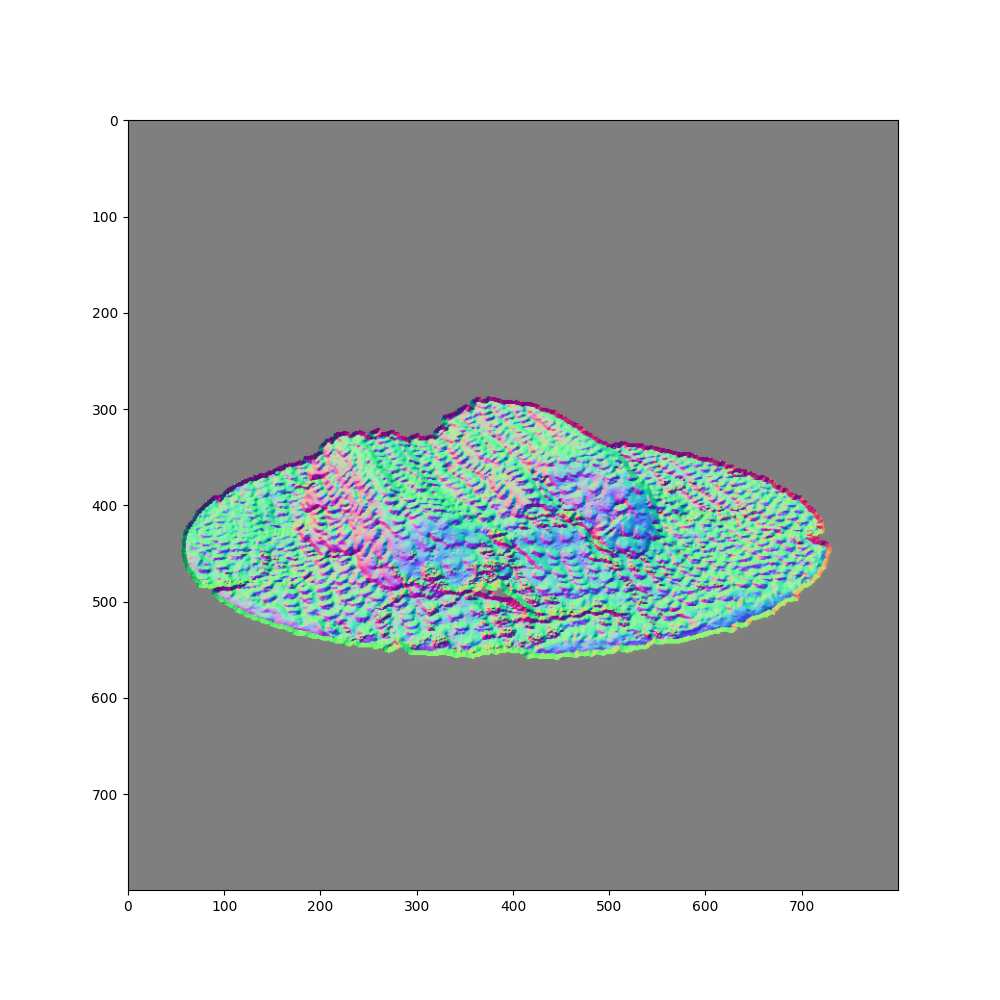

In [12]:

image_normals.detach().cpu().numpy().transpose(1, 2, 0).shape
# This one is much more efficient
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)


plt.figure(figsize=(10,10))
plt.imshow(image_normals_np)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(denoise_tv_chambolle(image_normals_np, weight=0.05, channel_axis=-1))
plt.show()






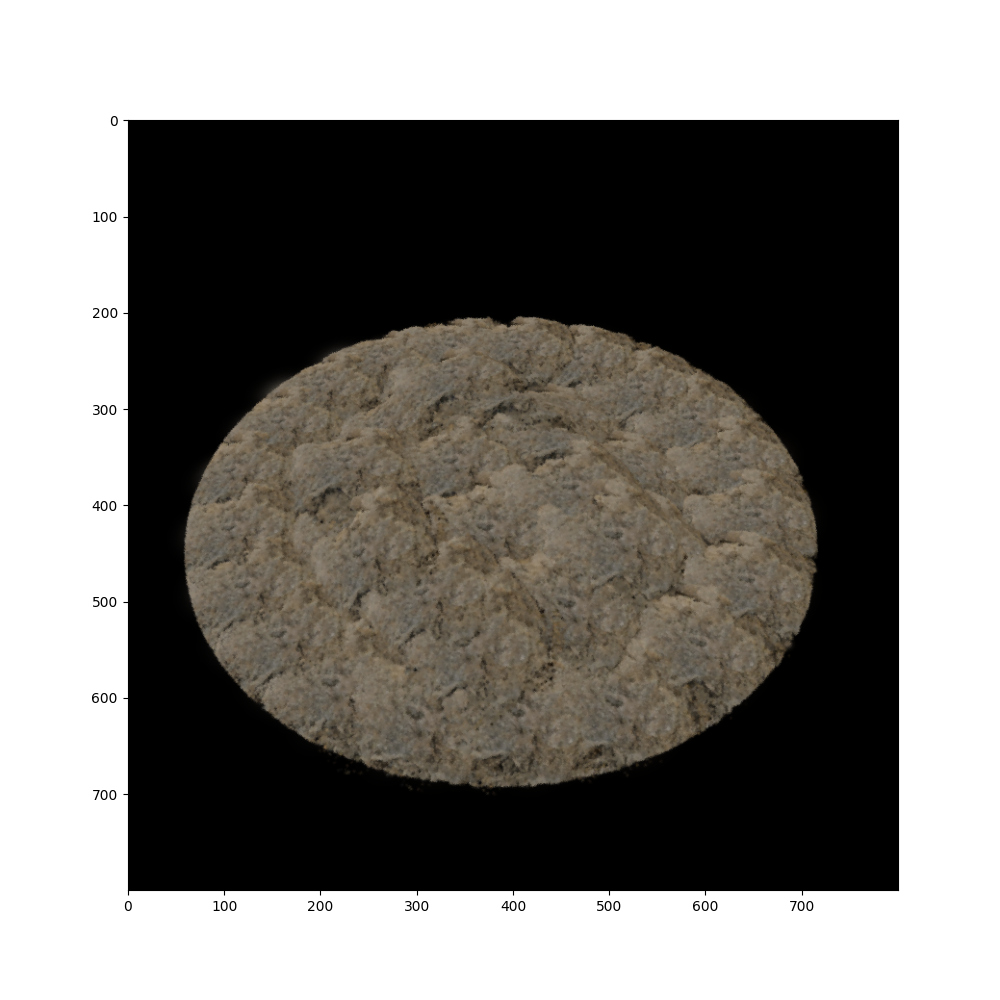

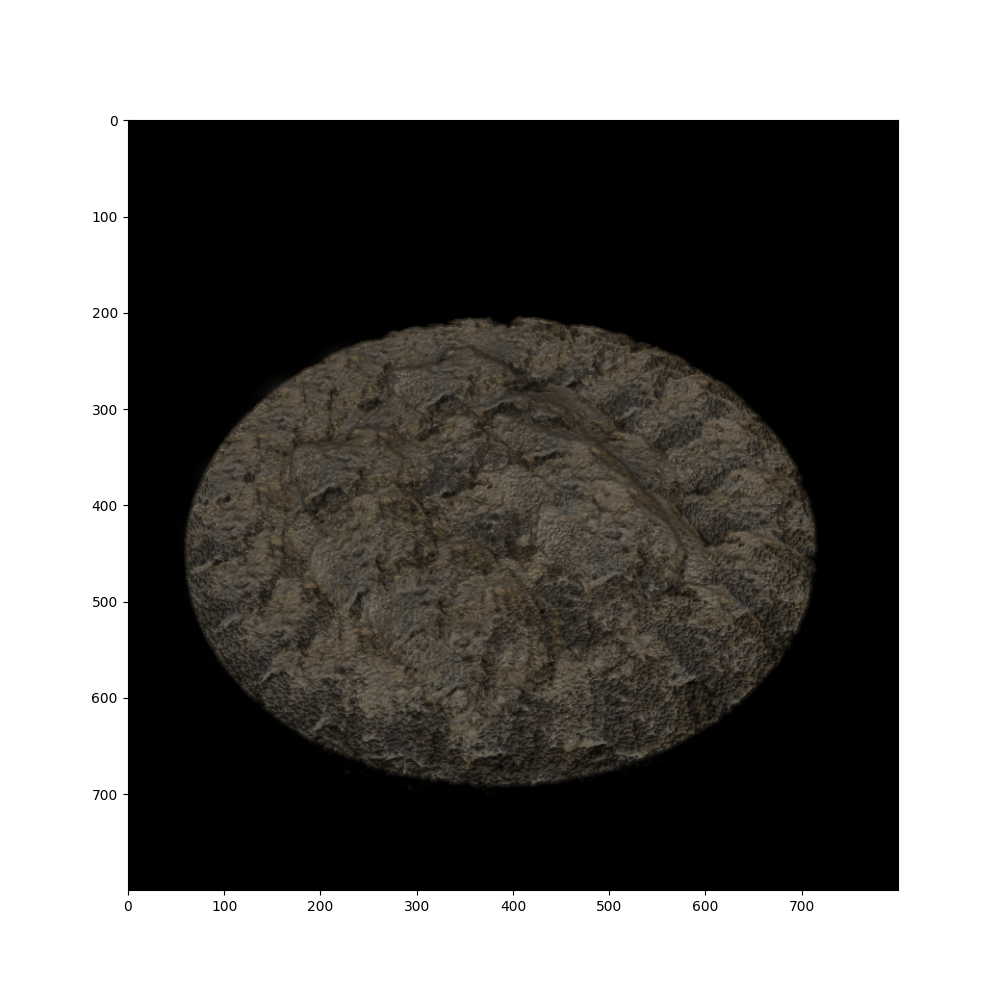

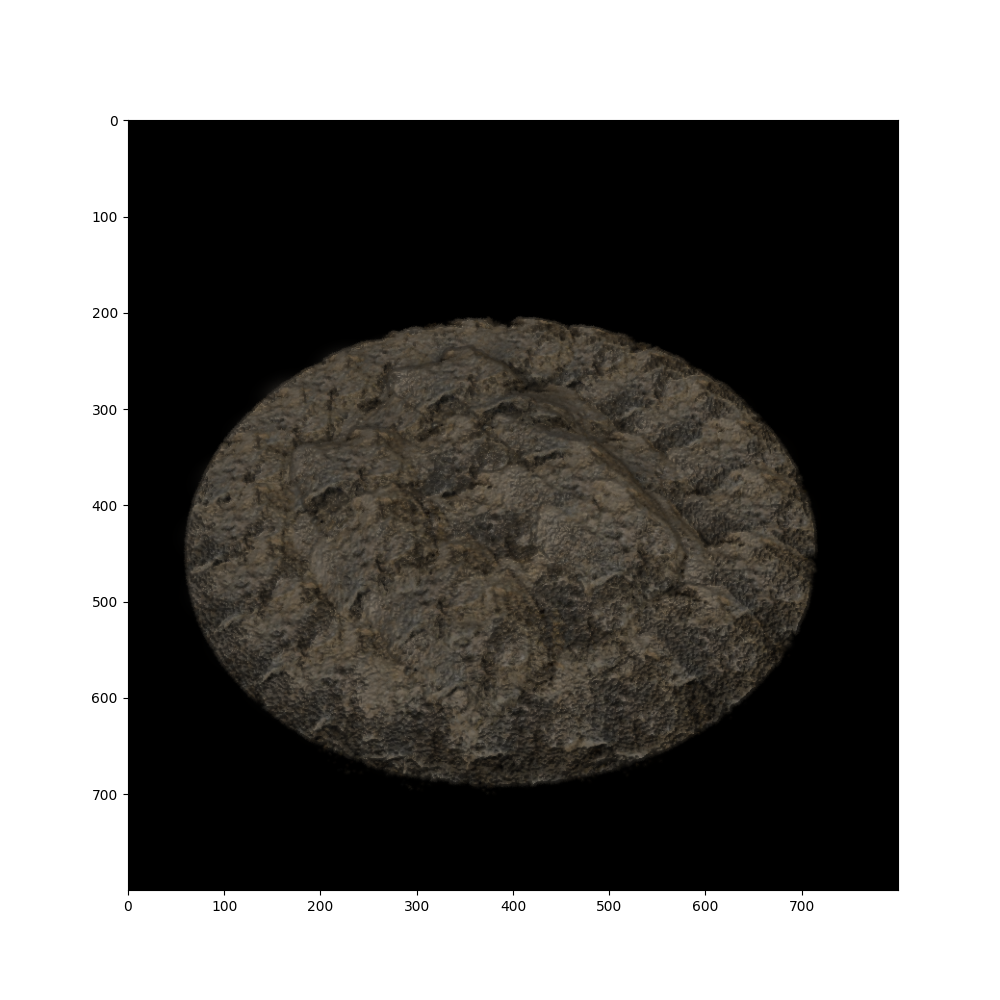

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(image_opt.detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

image_shaded = shade_image(img_color=image_opt.detach().cpu().numpy().transpose(1, 2, 0),
            img_normals=image_normals.detach().cpu().numpy().transpose(1, 2, 0),
                          ambnt_lght=np.array([.1,.1,.1])*0.5,
                          drct_lght_color=[1., 1., 1.],
                          drct_lght_dir = [-.2, -.3, 2.6])

plt.figure(figsize=(10,10))
plt.imshow(image_shaded)
plt.show()


image_normals_denoised = denoise_tv_chambolle(image_normals_np, weight=0.01, channel_axis=-1)
image_shaded = shade_image(img_color=image_opt.detach().cpu().numpy().transpose(1, 2, 0),
            img_normals=image_normals_denoised,
                          ambnt_lght=np.array([.1,.1,.1])*0.5,
                          drct_lght_color=[1., 1., 1.],
                          drct_lght_dir = [-.2, -.3, 2.6])
plt.figure(figsize=(10,10))
plt.imshow(image_shaded)
plt.show()

# Now fit new gaussian to the target scene

In [13]:
gaussians = GaussianModel(3)
scene = Scene(dataset, gaussians, shuffle=True)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [14]:
gaussians._xyz.data = opt_gaussians._xyz.data.clone().detach()
gaussians._features_dc.data = opt_gaussians._features_dc.data.clone().detach()
gaussians._features_rest.data = opt_gaussians._features_rest.data.clone().detach()
gaussians._rotation.data = opt_gaussians._rotation.data.clone().detach()
gaussians._scaling.data = opt_gaussians._scaling.data.clone().detach()
gaussians._opacity.data = opt_gaussians._opacity.data.clone().detach()
gaussians.max_radii2D.data = opt_gaussians.max_radii2D.data.clone().detach()
gaussians.xyz_gradient_accum.data = opt_gaussians.xyz_gradient_accum.data.clone().detach()
gaussians.denom.data = opt_gaussians.denom.data.clone().detach()




In [15]:
gaussians._scaling.data /= 1.05

In [16]:
gaussians.training_setup(opt)

gaussians._xyz.requires_grad = False
gaussians._features_dc.requires_grad = True
gaussians._features_rest.requires_grad = True
gaussians._scaling.requires_grad = False
gaussians._rotation.requires_grad = False
gaussians._opacity.requires_grad = False
gaussians.max_radii2D.requires_grad = False

In [17]:
# Render
render_pkg = render(viewpoint_cam, gaussians, pipe, background)
image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]


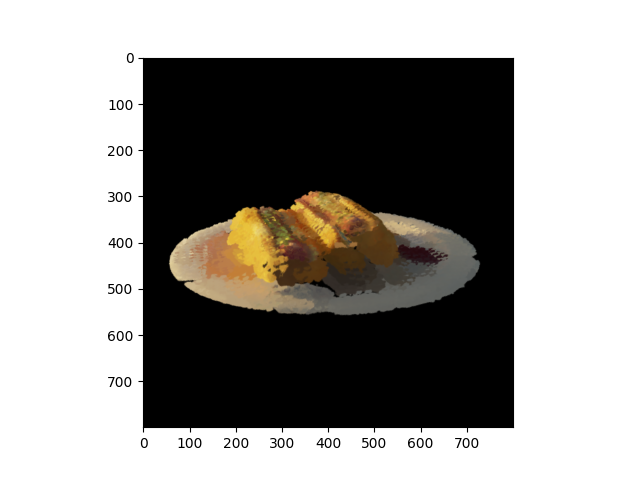

In [18]:
# Render
render_pkg = render(viewpoint_cam, gaussians, pipe, background)
image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

plt.figure()
plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [19]:

losses = []


In [20]:
viewpoint_cam_gt_list = []
viewpoint_stack = scene.getTrainCameras().copy()
for _ in tqdm(range(len(viewpoint_stack))):
# for _ in tqdm(range(5)):
    viewpoint_cam = viewpoint_stack.pop()

    # Compute GT_image
    render_pkg_opt = render(viewpoint_cam, gaussians, pipe, background)
    image_opt, depth_opt = render_pkg_opt["render"], render_pkg_opt["depth"]
    # plt.figure()
    # plt.imshow(image_opt.detach().cpu().numpy().transpose(1, 2, 0))
    # plt.show()
    

    K = torch.tensor([[1111, 0, 400],
                  [0, 1111, 400],
                  [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
    normals = kornia.geometry.depth.depth_to_normals(depth=depth_opt.unsqueeze(0).unsqueeze(0),
                                                     camera_matrix=K,
                                                     normalize_points=False)
    image_normals = normals.squeeze(0)
    mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
    maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
    image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
    image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)
    image_normals_denoised = denoise_tv_chambolle(image_normals_np, weight=0.01, channel_axis=-1)
    image_shaded = shade_image(img_color=image_opt.detach().cpu().numpy().transpose(1, 2, 0),
                img_normals=image_normals_denoised,
                              ambnt_lght=np.array([.1,.1,.1])*0.5,
                              drct_lght_color=[1., 1., 1.],
                              drct_lght_dir = [-.2, -.3, 2.6])

    viewpoint_cam_gt_list.append((viewpoint_cam, image_shaded))
    #print("camera popped")
    
    

/tmp/ipykernel_3949680/2689083565.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(len(viewpoint_stack))):


  0%|          | 0/300 [00:00<?, ?it/s]

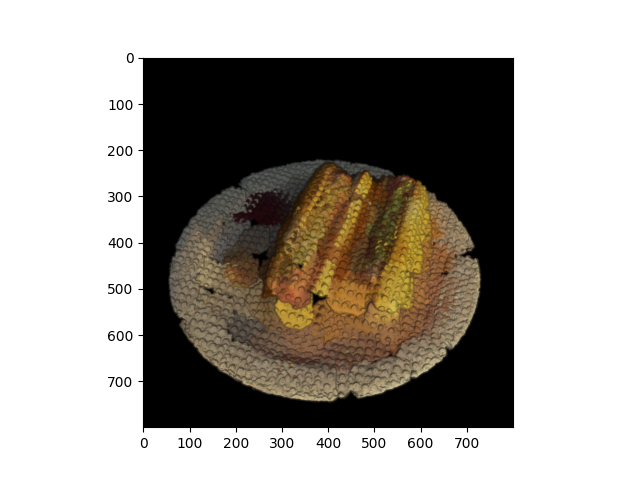

In [21]:
plt.figure()
plt.imshow(viewpoint_cam_gt_list[1][1])
plt.show()

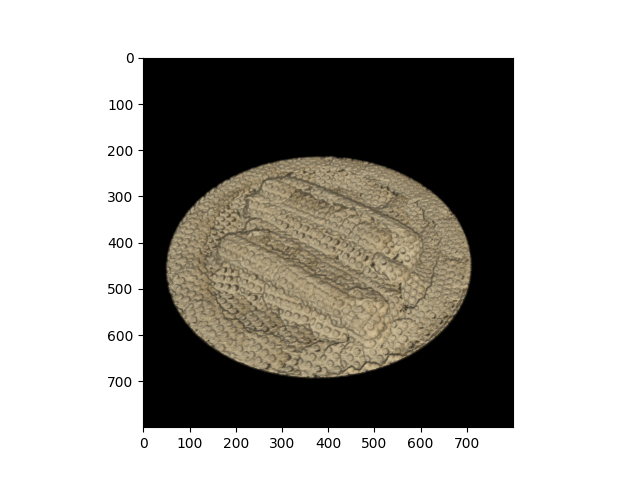

In [160]:
plt.figure()
plt.imshow(viewpoint_cam_gt_list[0][1])
plt.show()

In [33]:
len(viewpoint_cam_gt_list)

300

In [22]:

from utils.loss_utils import l1_loss, ssim, VGG, content_loss, style_loss, get_features, tv_loss
import random
first_iter = 1100
viewpoint_stack = None
ema_loss_for_log = 0.0
progress_bar = tqdm(range(first_iter, 10000), desc="Training progress")

for iteration in range(first_iter, opt.iterations + 1):
    gaussians.update_learning_rate(iteration)

    # Every 1000 its we increase the levels of SH up to a maximum degree
    if iteration % 1000 == 0:
        gaussians.oneupSHdegree()

    # Pick a (random Camera, image_shaded) pair
    viewpoint_cam, image_shaded = random.sample(viewpoint_cam_gt_list,1)[0]
    
    
    # Render
    render_pkg = render(viewpoint_cam, gaussians, pipe, background)
    image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

    # Loss
    gt_image = torch.tensor(image_shaded.transpose(2, 0, 1), dtype=torch.float32).cuda()
    # print(gt_image.shape, image.shape)
    # plt.figure()
    # plt.imshow(gt_image.cpu().numpy().transpose(1, 2, 0))
    # plt.show()

    if (iteration % 100 == 0) and False:
        plt.figure()
        plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
        plt.show()
    
    Ll1 = l1_loss(image, gt_image)
    
    # Pixel loss (original)
    loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim(image, gt_image))
    losses.append(float(loss.detach().cpu().numpy()))
    loss.backward()
    with torch.no_grad():
        # Progress bar
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        if iteration % 10 == 0:
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
            progress_bar.update(10)
        if iteration == opt.iterations:
            progress_bar.close()

        # Densification
        if iteration < opt.densify_until_iter:
            # Keep track of max radii in image-space for pruning
            gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
            gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

            if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
                size_threshold = 20 if iteration > opt.opacity_reset_interval else None
                gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold)

            # if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
            #     gaussians.reset_opacity()

        # Optimizer step
        if iteration < opt.iterations:
            gaussians.optimizer.step()
            gaussians.optimizer.zero_grad(set_to_none = True)

        

/tmp/ipykernel_3949680/3243029243.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(range(first_iter, 10000), desc="Training progress")


Training progress:   0%|          | 0/8900 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [111]:

# from utils.loss_utils import l1_loss, ssim, VGG, content_loss, style_loss, get_features, tv_loss
# first_iter = 1100
# viewpoint_stack = None
# ema_loss_for_log = 0.0
# progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")

# for iteration in range(first_iter, opt.iterations + 1):
#     gaussians.update_learning_rate(iteration)

#     # Every 1000 its we increase the levels of SH up to a maximum degree
#     if iteration % 1000 == 0:
#         gaussians.oneupSHdegree()

#     # Pick a random Camera
#     if not viewpoint_stack:
#         viewpoint_stack = scene.getTrainCameras().copy()
#     viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

#     # Compute GT_image
#     render_pkg_opt = render(viewpoint_cam, opt_gaussians, pipe, background)
#     image_opt, depth_opt = render_pkg_opt["render"], render_pkg_opt["depth"]
#     # plt.figure()
#     # plt.imshow(image_opt.detach().cpu().numpy().transpose(1, 2, 0))
#     # plt.show()
    

#     K = torch.tensor([[1111, 0, 400],
#                   [0, 1111, 400],
#                   [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
#     normals = kornia.geometry.depth.depth_to_normals(depth=depth_opt.unsqueeze(0).unsqueeze(0),
#                                                      camera_matrix=K,
#                                                      normalize_points=False)
#     image_normals = normals.squeeze(0)
#     mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
#     maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
#     image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
#     image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)
#     image_normals_denoised = denoise_tv_chambolle(image_normals_np, weight=0.1, channel_axis=-1)
#     image_shaded = shade_image(img_color=image_opt.detach().cpu().numpy().transpose(1, 2, 0),
#                 img_normals=image_normals_denoised,
#                               ambnt_lght=np.array([.1,.1,.1])*0.5,
#                               drct_lght_color=[1., 1., 1.],
#                               drct_lght_dir = [-.2, -.3, 2.6])
    
    
#     # Render
#     render_pkg = render(viewpoint_cam, gaussians, pipe, background)
#     image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

#     # Loss
#     gt_image = torch.tensor(image_shaded.transpose(2, 0, 1), dtype=torch.float32).cuda()
#     # print(gt_image.shape, image.shape)
#     # plt.figure()
#     # plt.imshow(gt_image.cpu().numpy().transpose(1, 2, 0))
#     # plt.show()

#     if (iteration % 100 == 0) and False:
#         plt.figure()
#         plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
#         plt.show()
    
#     Ll1 = l1_loss(image, gt_image)
    
#     # Pixel loss (original)
#     loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim(image, gt_image))
#     losses.append(float(loss.detach().cpu().numpy()))
#     loss.backward()
#     with torch.no_grad():
#         # Progress bar
#         ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
#         if iteration % 10 == 0:
#             progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
#             progress_bar.update(10)
#         if iteration == opt.iterations:
#             progress_bar.close()

#         # Densification
#         if iteration < opt.densify_until_iter:
#             # Keep track of max radii in image-space for pruning
#             gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
#             gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

#             if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
#                 size_threshold = 20 if iteration > opt.opacity_reset_interval else None
#                 gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold)

#             # if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
#             #     gaussians.reset_opacity()

#         # Optimizer step
#         if iteration < opt.iterations:
#             gaussians.optimizer.step()
#             gaussians.optimizer.zero_grad(set_to_none = True)

        

/tmp/ipykernel_2088542/3426033967.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")


Training progress:   0%|          | 0/29300 [00:00<?, ?it/s]

KeyboardInterrupt: 

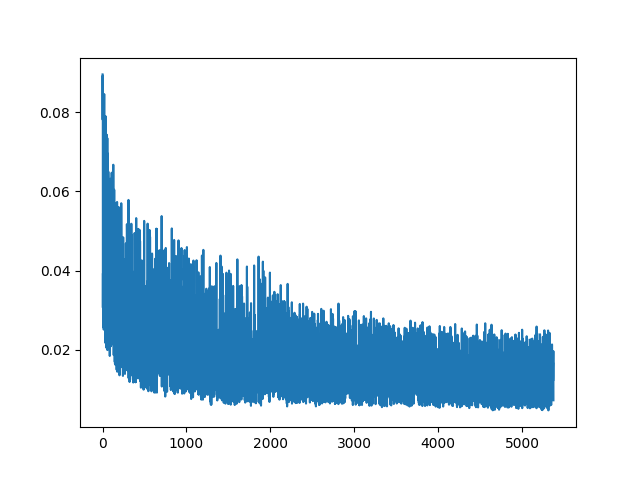

In [23]:
plt.figure()
plt.plot(losses)
plt.show()

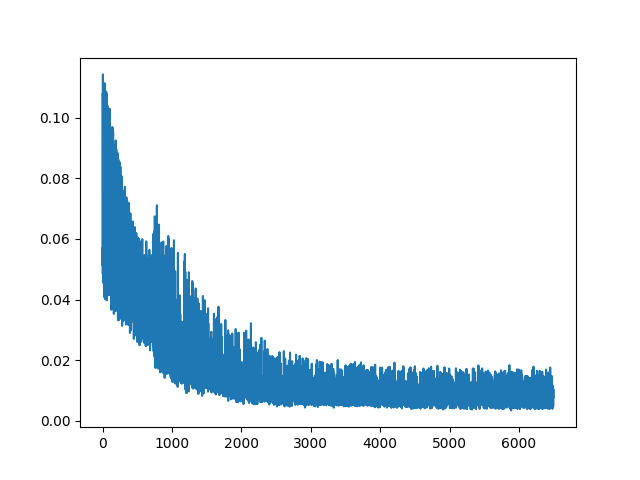

In [132]:
plt.figure()
plt.plot(losses)
plt.show()

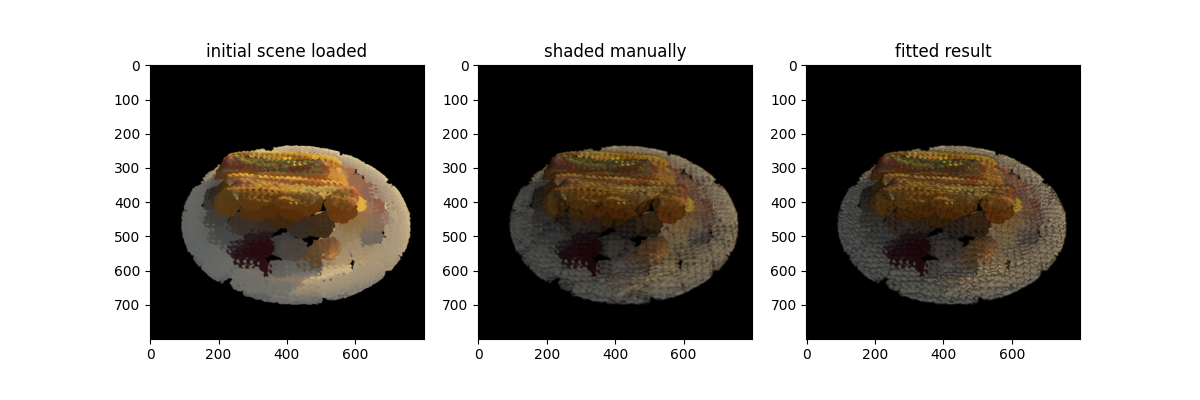

In [24]:
# Sample camera 
if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
# Render
render_pkg_opt = render(viewpoint_cam, opt_gaussians, pipe, background)
image_opt, depth_opt = render_pkg_opt["render"], render_pkg_opt["depth"]

K = torch.tensor([[1111, 0, 400],
                  [0, 1111, 400],
                  [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
normals = kornia.geometry.depth.depth_to_normals(depth=depth_opt.unsqueeze(0).unsqueeze(0),
                                                 camera_matrix=K,
                                                 normalize_points=False)
image_normals = normals.squeeze(0)
mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)
image_normals_denoised = denoise_tv_chambolle(image_normals_np, weight=0.1, channel_axis=-1)
image_shaded = shade_image(img_color=image_opt.detach().cpu().numpy().transpose(1, 2, 0),
            img_normals=image_normals_denoised,
                          ambnt_lght=np.array([.1,.1,.1])*0.5,
                          drct_lght_color=[1., 1., 1.],
                          drct_lght_dir = [-.2, -.3, 2.6])


render_pkg = render(viewpoint_cam, gaussians, pipe, background)
image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].set_title("initial scene loaded")
ax[0].imshow(image_opt.detach().cpu().numpy().transpose(1, 2, 0))

ax[1].set_title("shaded manually")
ax[1].imshow(image_shaded)

ax[2].set_title("fitted result")
ax[2].imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

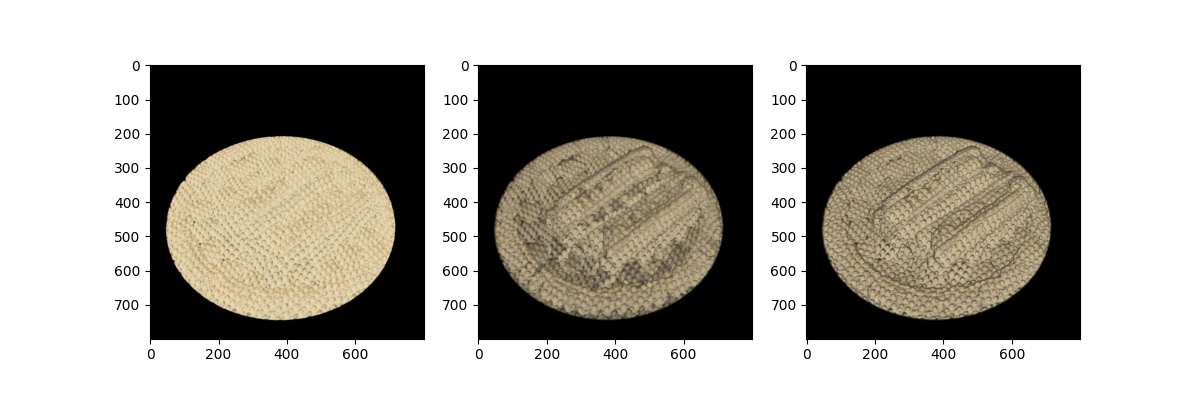

In [165]:
# Sample camera 
if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
# Render
render_pkg_opt = render(viewpoint_cam, opt_gaussians, pipe, background)
image_opt, depth_opt = render_pkg_opt["render"], render_pkg_opt["depth"]

K = torch.tensor([[1111, 0, 400],
                  [0, 1111, 400],
                  [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
normals = kornia.geometry.depth.depth_to_normals(depth=depth_opt.unsqueeze(0).unsqueeze(0),
                                                 camera_matrix=K,
                                                 normalize_points=False)
image_normals = normals.squeeze(0)
mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)
image_normals_denoised = denoise_tv_chambolle(image_normals_np, weight=0.1, channel_axis=-1)
image_shaded = shade_image(img_color=image_opt.detach().cpu().numpy().transpose(1, 2, 0),
            img_normals=image_normals_denoised,
                          ambnt_lght=np.array([.1,.1,.1])*0.5,
                          drct_lght_color=[1., 1., 1.],
                          drct_lght_dir = [-.2, -.3, 2.6])


render_pkg = render(viewpoint_cam, gaussians, pipe, background)
image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].imshow(image_opt.detach().cpu().numpy().transpose(1, 2, 0))

ax[1].imshow(image_shaded)

ax[2].imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

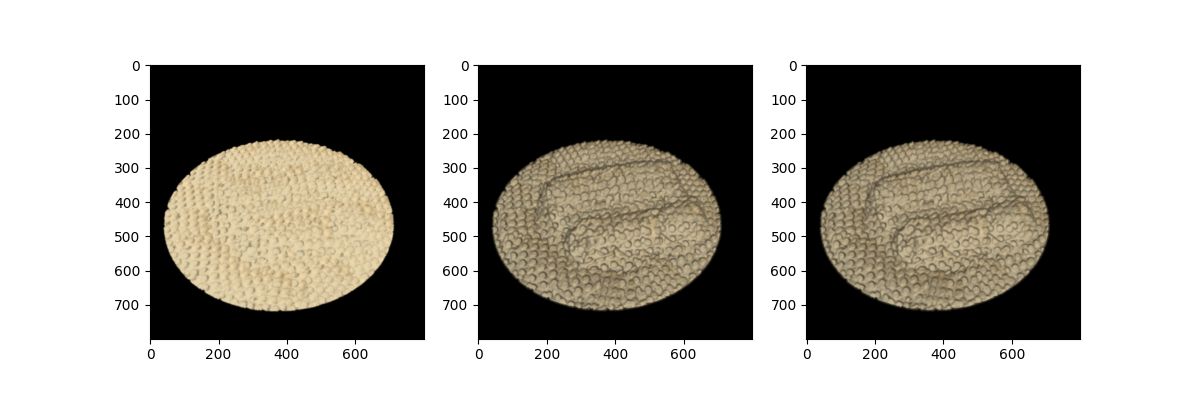

In [133]:
# Sample camera 
if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
# Render
render_pkg_opt = render(viewpoint_cam, opt_gaussians, pipe, background)
image_opt, depth_opt = render_pkg_opt["render"], render_pkg_opt["depth"]

K = torch.tensor([[1111, 0, 400],
                  [0, 1111, 400],
                  [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
normals = kornia.geometry.depth.depth_to_normals(depth=depth_opt.unsqueeze(0).unsqueeze(0),
                                                 camera_matrix=K,
                                                 normalize_points=False)
image_normals = normals.squeeze(0)
mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)
image_normals_denoised = denoise_tv_chambolle(image_normals_np, weight=0.1, channel_axis=-1)
image_shaded = shade_image(img_color=image_opt.detach().cpu().numpy().transpose(1, 2, 0),
            img_normals=image_normals_denoised,
                          ambnt_lght=np.array([.1,.1,.1])*0.5,
                          drct_lght_color=[1., 1., 1.],
                          drct_lght_dir = [-.2, -.3, 2.6])


render_pkg = render(viewpoint_cam, gaussians, pipe, background)
image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].imshow(image_opt.detach().cpu().numpy().transpose(1, 2, 0))

ax[1].imshow(image_shaded)

ax[2].imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [25]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/'
MODEL_DIR_NEW = './fit_hotdog_with_lego_200_clusters_v2_colored_shaded/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))



